# Data Loading

In [1]:
import kagglehub
import pandas as pd
import os
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
# Download latest version
path_job_posting = kagglehub.dataset_download("arshkon/linkedin-job-postings")
print("Path to job postings dataset files:", path_job_posting)

path_for_resume = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
print("Path to resume dataset files:", path_for_resume)

# Load Job Postings Data
job_postings = pd.read_csv(os.path.join(path_job_posting, 'postings.csv'))
job_skills = pd.read_csv(os.path.join(path_job_posting, 'jobs', 'job_skills.csv'))
salaries = pd.read_csv(os.path.join(path_job_posting, 'jobs', 'salaries.csv'))
skills = pd.read_csv(os.path.join(path_job_posting, 'mappings', 'skills.csv'))
companies = pd.read_csv(os.path.join(path_job_posting, 'companies', 'companies.csv'))
company_industries = pd.read_csv(os.path.join(path_job_posting, 'companies', 'company_industries.csv'))

# Load Resume Data
resume_df = pd.read_csv(os.path.join(path_for_resume, 'Resume', 'Resume.csv'))

Path to job postings dataset files: /kaggle/input/linkedin-job-postings
Path to resume dataset files: /kaggle/input/resume-dataset


# Data Cleaning & Preprocessing

In [10]:
from typing_extensions import final
# --- 2.1 Prepare and aggregate skills data ---
skills_df_merged = pd.merge(job_skills, skills, on='skill_abr', how='left')
aggregated_skills = skills_df_merged.groupby('job_id')['skill_name'].apply(lambda x: ','.join(x.dropna().unique())).reset_index()
aggregated_skills.rename(columns={'skill_name': 'skills_list'}, inplace=True)

# --- 2.2 Prepare company data and aggregate industries ---
companies.rename(columns={'name': 'company_name_from_companies'}, inplace=True)
merged_companies_data = pd.merge(companies, company_industries, on='company_id', how='left')
company_industries_agg = merged_companies_data.groupby('company_id')['industry'].apply(lambda x: ','.join(x.dropna().unique())).reset_index()
company_industries_agg.rename(columns={'industry': 'company_industries_list'}, inplace=True)

# --- 2.3 Prepare Salary data from salaries.csv ---
salaries_cleaned = salaries.copy()
salaries_cleaned['pay_period'] = salaries_cleaned['pay_period'].str.lower().str.strip()

def convert_to_yearly_salary(row):
    min_sal = pd.to_numeric(row['min_salary'], errors='coerce')
    max_sal = pd.to_numeric(row['max_salary'], errors='coerce')
    med_sal = pd.to_numeric(row['med_salary'], errors='coerce')

    if pd.notnull(med_sal):
        avg_sal = med_sal
    elif pd.notnull(min_sal) and pd.notnull(max_sal):
        avg_sal = (min_sal + max_sal) / 2
    elif pd.notnull(min_sal):
        avg_sal = min_sal
    elif pd.notnull(max_sal):
        avg_sal = max_sal
    else:
        return np.nan

    if row['pay_period'] == 'hourly':
        return avg_sal * 40 * 52
    elif row['pay_period'] == 'weekly':
        return avg_sal * 52
    elif row['pay_period'] == 'biweekly':
        return avg_sal * 26
    elif row['pay_period'] == 'monthly':
        return avg_sal * 12
    elif row['pay_period'] == 'yearly':
        return avg_sal
    else:
        return np.nan

salaries_cleaned['calculated_yearly_salary'] = salaries_cleaned.apply(convert_to_yearly_salary, axis=1)
job_calculated_salaries = salaries_cleaned.groupby('job_id')['calculated_yearly_salary'].median().reset_index()

# --- 2.4 Main Merging Process ---
final_job_df = job_postings.copy()

# Merge with calculated salaries
final_job_df = pd.merge(final_job_df, job_calculated_salaries, on='job_id', how='left')

# Merge with company details and industries
company_cols_to_merge = ['company_id', 'company_name_from_companies', 'company_size', 'state', 'country', 'city', 'address', 'zip_code']
company_info_for_merge = merged_companies_data[company_cols_to_merge].drop_duplicates(subset=['company_id'])

final_job_df = pd.merge(final_job_df, company_info_for_merge,
                        left_on='company_id', right_on='company_id', how='left',
                        suffixes=('_job_posting', '_company_info'))

final_job_df['company_name'] = final_job_df['company_name_from_companies'].fillna(final_job_df['company_name'])
final_job_df.drop(columns=['company_name_from_companies'], inplace=True)

final_job_df = pd.merge(final_job_df, company_industries_agg, on='company_id', how='left')
final_job_df = pd.merge(final_job_df, aggregated_skills, on='job_id', how='left')

# Final salary column
final_job_df['final_yearly_salary'] = final_job_df['normalized_salary'].fillna(final_job_df['calculated_yearly_salary'])

# Drop unused columns
final_job_df.drop(columns=['max_salary', 'min_salary', 'med_salary', 'normalized_salary', 'calculated_yearly_salary', 'skills_desc', 'original_listed_time','job_posting_url', 'application_url', 'listed_time',
                          'application_type', 'expiry', 'closed_time', 'posting_domain', 'company_id', 'views', 'applies', 'work_type', 'zip_code_job_posting', 'fips', 'city', 'state', 'country', 'address', 'zip_code_company_info', 'company_size' ],
                           errors='ignore', inplace=True)

# Final Job Data frame after renaming
final_job_df.rename(columns={'title': 'job_title', 'description': 'job_description', 'location': 'job_posting_location', 'formatted_work_type': 'Work_type','formatted_experience_level': 'Experience_level',
                              }, inplace=True)

print("Job postings merged into final_job_df.")

Job postings merged into final_job_df.


In [11]:
final_job_df.head()

,job_id,company_name,job_title,job_description,pay_period,job_posting_location,Work_type,remote_allowed,Experience_level,sponsored,currency,compensation_type,company_industries_list,skills_list,final_yearly_salary
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,HOURLY,"Princeton, NJ",Full-time,NaN,NaN,0,USD,BASE_SALARY,Real Estate,"Marketing,Sales",38480.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",HOURLY,"Fort Collins, CO",Full-time,NaN,NaN,0,USD,BASE_SALARY,NaN,Health Care Provider,83200.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,YEARLY,"Cincinnati, OH",Full-time,NaN,NaN,0,USD,BASE_SALARY,Restaurants,"Management,Manufacturing",55000.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,YEARLY,"New Hyde Park, NY",Full-time,NaN,NaN,0,USD,BASE_SALARY,Law Practice,Other,157500.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,YEARLY,"Burlington, IA",Full-time,NaN,NaN,0,USD,BASE_SALARY,NaN,Information Technology,70000.0


In [12]:
final_job_df.shape

(123849, 15)

In [13]:
final_job_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   job_id                   123849 non-null  int64  
 1   company_name             122130 non-null  object 
 2   job_title                123849 non-null  object 
 3   job_description          123842 non-null  object 
 4   pay_period               36073 non-null   object 
 5   job_posting_location     123849 non-null  object 
 6   Work_type                123849 non-null  object 
 7   remote_allowed           15246 non-null   float64
 8   Experience_level         94440 non-null   object 
 9   sponsored                123849 non-null  int64  
 10  currency                 36073 non-null   object 
 11  compensation_type        36073 non-null   object 
 12  company_industries_list  122131 non-null  object 
 13  skills_list              122096 non-null  object 
 14  fina

In [14]:
resume_df.drop(columns=['Resume_html'], inplace=True)

In [15]:
resume_df.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


In [16]:
resume_df.shape

(2484, 3)

## Remove Duplicates:

In [17]:
final_job_df.drop_duplicates(subset=['job_id'], inplace=True)
resume_df.drop_duplicates(subset=['Resume_str'], inplace=True)
print(f"Job postings after duplicate removal: {len(final_job_df)}")
print(f"Resumes after duplicate removal: {len(resume_df)}")

Job postings after duplicate removal: 123849
Resumes after duplicate removal: 2482


## Standardize Column Formats & Handle Missing Values


In [18]:
final_job_df.isna().sum().sort_values(ascending=False)

,0
remote_allowed,108603
currency,87776
pay_period,87776
compensation_type,87776
final_yearly_salary,87776
Experience_level,29409
skills_list,1753
company_name,1719
company_industries_list,1718
job_description,7


In [19]:
resume_df.isna().sum().sort_values(ascending=False)

,0
ID,0
Resume_str,0
Category,0


In [42]:
# For final_job_df
final_job_df['remote_allowed'] = final_job_df['remote_allowed'].fillna(0).astype(bool)
final_job_df['final_yearly_salary'] = pd.to_numeric(final_job_df['final_yearly_salary'], errors='coerce')

text_cols_job = [
    'company_name', 'description', 'location', 'Work_type',
    'currency', 'pay_period', 'compensation_type', 'Experience_level',
    'company_industries_list', 'skills_list']
for col in text_cols_job:
    if col in final_job_df.columns:
        final_job_df[col] = final_job_df[col].astype(str).str.lower().str.strip()
        final_job_df[col] = final_job_df[col].replace('nan', np.nan).fillna('Not Specified')

# Drop rows where 'job_description' is NaN
final_job_df.dropna(subset=['job_description'], inplace=True)

In [43]:
final_job_df.head()

,job_id,company_name,job_title,pay_period,job_posting_location,Work_type,remote_allowed,Experience_level,sponsored,currency,compensation_type,company_industries_list,skills_list,final_yearly_salary,job_description
0,921716,corcoran sawyer smith,Marketing Coordinator,hourly,"Princeton, NJ",full-time,False,not specified,0,usd,base_salary,real estate,"marketing,sales",38480.0,Job description A leading real estate firm in ...
1,1829192,not specified,Mental Health Therapist/Counselor,hourly,"Fort Collins, CO",full-time,False,not specified,0,usd,base_salary,not specified,health care provider,83200.0,"At Aspen Therapy and Wellness , we are committ..."
2,10998357,the national exemplar,Assitant Restaurant Manager,yearly,"Cincinnati, OH",full-time,False,not specified,0,usd,base_salary,restaurants,"management,manufacturing",55000.0,The National Exemplar is accepting application...
3,23221523,"abrams fensterman, llp",Senior Elder Law / Trusts and Estates Associat...,yearly,"New Hyde Park, NY",full-time,False,not specified,0,usd,base_salary,law practice,other,157500.0,Senior Associate Attorney - Elder Law / Trus...
4,35982263,not specified,Service Technician,yearly,"Burlington, IA",full-time,False,not specified,0,usd,base_salary,not specified,information technology,70000.0,Looking for HVAC service tech with experience ...


In [23]:
final_job_df.isna().sum().sort_values(ascending=False)

,0
final_yearly_salary,87770
company_name,0
job_id,0
job_description,0
pay_period,0
job_posting_location,0
job_title,0
Work_type,0
remote_allowed,0
sponsored,0


# Feature Engineering (Skills Extraction using NLP)

## Applying Preprocessing to Job Descriptions and Resumes

In [24]:
final_job_df['job_description'][1]

'At Aspen Therapy and Wellness , we are committed to serving clients with best practices to help them with change, improvements and better quality of life. We believe in providing a secure, supportive environment to grow as a clinician and learn how to foster longevity in the career which is part of our mission statement.\nThank you for taking the time to explore a career with us. We are excited to be a new group practice in the community. If you are looking for quality supervision as you work towards licensure and ability to serve populations while accepting a variety of insurance panels, we may be a good fit. Our supervisors are trained in EMDR and utilize a parts work perspective with a trauma lens.\nWe are actively looking to hire a therapist in the area who is passionate about working with adults and committed to growth and excellence in the field. We are located in Old Town Square, Fort Collins.\nWe value and are strengthened by diversity and desire a warm and welcoming place for

In [25]:
resume_df['Resume_str'][1]

"         HR SPECIALIST, US HR OPERATIONS       Summary     Versatile  media professional with background in Communications, Marketing, Human Resources and Technology.\xa0        Experience     09/2015   to   Current     HR Specialist, US HR Operations    Company Name   －   City  ,   State       Managed communication regarding launch of Operations group, policy changes and system outages      Designed standard work and job aids to create comprehensive training program for new employees and contractors         Audited job postings for old, pending, on-hold and draft positions.           Audited union hourly, non-union hourly and salary background checks and drug screens             Conducted monthly new hire benefits briefing to new employees across all business units               Served as a link between HR Managers and vendors by handling questions and resolving system-related issues         Provide real-time process improvement feedback on key metrics and initiatives  Successfully r

In [26]:
import re
import pandas as pd
import spacy

def clean_text(text, lemmatize=False):
    if pd.isna(text):
        return ""

    # Basic cleaning
    text = text.encode('ascii', 'ignore').decode('utf-8')  # Remove \xa0 and non-ascii
    text = re.sub(r'\\n|\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Add space between lowercase-uppercase transitions (camelCase or PascalCase)
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # Add space after punctuation if missing
    text = re.sub(r'([.,;:])(?=\w)', r'\1 ', text)

    # Add space between words stuck together (heuristic: lowercase then uppercase)
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # Add space between letters and numbers (e.g., W2Employment → W2 Employment)
    text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)
    text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)

    # Normalize bullet markers
    text = re.sub(r'[•·\-\*]+', ' - ', text)

    # Fix spacing issues around common job keywords
    text = re.sub(r'([a-z])([A-Z][a-z])', r'\1 \2', text)

    # Optional: lemmatize
    if lemmatize:
        doc = nlp(text)
        text = ' '.join([token.lemma_ for token in doc if not token.is_punct])

    return text.strip()


In [28]:
# Apply cleaning to long text fields
final_job_df['cleaned_job_description'] = final_job_df['job_description'].apply(lambda x: clean_text(x))

# Apply to resume dataset
resume_df['cleaned_resume'] = resume_df['Resume_str'].apply(lambda x: clean_text(x))


In [29]:
resume_df['cleaned_resume'][3]

'HR SPECIALIST Summary Dedicated, Driven, and Dynamic with over 20 years of customer service expertise. Motivated to maintain customer satisfaction and contribute to company success with an emphasis in personnel and process management. Solid team player with proven ability to establish rapport with clients. Skills Type 50 wpm and 10 - Key by touch Microsoft programs Word, Excel, Access, Outlook, Power Point Personnel management and Telephone inquiries specialist Excellent customer service skills with call quality and customer satisfaction as primary focus. Inbound and Outbound contact center experience Excellent oral and written presentation and seasoned in conflict resolution Experience Hr Specialist May 2007 to Oct 2008 Company Name City , State Accenture Peopleline Email Management Team. Received inbound emails from clients as initial point of contact to answer questions related to HR policies, practices or to resolve issues. Helped the client by answering their inquiry, resolving t

In [30]:
final_job_df['cleaned_job_description'][1]

'At Aspen Therapy and Wellness , we are committed to serving clients with best practices to help them with change, improvements and better quality of life. We believe in providing a secure, supportive environment to grow as a clinician and learn how to foster longevity in the career which is part of our mission statement. Thank you for taking the time to explore a career with us. We are excited to be a new group practice in the community. If you are looking for quality supervision as you work towards licensure and ability to serve populations while accepting a variety of insurance panels, we may be a good fit. Our supervisors are trained in EMDR and utilize a parts work perspective with a trauma lens. We are actively looking to hire a therapist in the area who is passionate about working with adults and committed to growth and excellence in the field. We are located in Old Town Square, Fort Collins. We value and are strengthened by diversity and desire a warm and welcoming place for al

In [31]:
final_job_df.drop(columns=['job_description'], inplace=True)
final_job_df.rename(columns={'cleaned_job_description': 'job_description'}, inplace=True)

In [32]:
resume_df.drop(columns=['Resume_str'], inplace=True)


In [33]:
final_job_df.head()

,job_id,company_name,job_title,pay_period,job_posting_location,Work_type,remote_allowed,Experience_level,sponsored,currency,compensation_type,company_industries_list,skills_list,final_yearly_salary,job_description
0,921716,corcoran sawyer smith,Marketing Coordinator,hourly,"Princeton, NJ",full-time,False,not specified,0,usd,base_salary,real estate,"marketing,sales",38480.0,Job description A leading real estate firm in ...
1,1829192,not specified,Mental Health Therapist/Counselor,hourly,"Fort Collins, CO",full-time,False,not specified,0,usd,base_salary,not specified,health care provider,83200.0,"At Aspen Therapy and Wellness , we are committ..."
2,10998357,the national exemplar,Assitant Restaurant Manager,yearly,"Cincinnati, OH",full-time,False,not specified,0,usd,base_salary,restaurants,"management,manufacturing",55000.0,The National Exemplar is accepting application...
3,23221523,"abrams fensterman, llp",Senior Elder Law / Trusts and Estates Associat...,yearly,"New Hyde Park, NY",full-time,False,not specified,0,usd,base_salary,law practice,other,157500.0,Senior Associate Attorney - Elder Law / Trus...
4,35982263,not specified,Service Technician,yearly,"Burlington, IA",full-time,False,not specified,0,usd,base_salary,not specified,information technology,70000.0,Looking for HVAC service tech with experience ...


In [34]:
resume_df.head()

,ID,Category,cleaned_resume
0,16852973,HR,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...
1,22323967,HR,"HR SPECIALIST, US HR OPERATIONS Summary Versat..."
2,33176873,HR,HR DIRECTOR Summary Over 20 years experience i...
3,27018550,HR,"HR SPECIALIST Summary Dedicated, Driven, and D..."
4,17812897,HR,HR MANAGER Skill Highlights HR SKILLS HR Depar...


###Statistical Summary


In [ ]:
print("\n--- Statistical Summary for Numerical Attributes ---")
final_job_df.describe()


--- Statistical Summary for Numerical Attributes ---


,job_id,sponsored,final_yearly_salary
count,1.238420e+05,123842.0,3.607200e+04
mean,3.896402e+09,0.0,2.053280e+05
std,8.404590e+07,0.0,5.097697e+06
min,9.217160e+05,0.0,0.000000e+00
25%,3.894587e+09,0.0,5.200000e+04
50%,3.901998e+09,0.0,8.150000e+04
75%,3.904707e+09,0.0,1.250000e+05
max,3.906267e+09,0.0,5.356000e+08


###Outlier Detection

In [35]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, len(outliers)

outlier_data = []
numerical_cols = final_job_df.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    # Handle potential NaN values in specific columns if necessary for IQR calculation
    if col == 'final_yearly_salary':
        temp_df = final_job_df.dropna(subset=[col])
    else:
        temp_df = final_job_df.copy()

    outliers, outlier_count = detect_outliers_iqr(temp_df, col)
    if len(temp_df) > 0:
        outlier_percentage = (outlier_count / len(temp_df)) * 100
    else:
        outlier_percentage = 0

    outlier_data.append({'Attribute': col, 'Outlier Count': outlier_count, 'Outlier Percentage': f"{outlier_percentage:.2f}%"})

outlier_table = pd.DataFrame(outlier_data)
print("\n--- Outlier Analysis ---")
display(outlier_table)


--- Outlier Analysis ---


,Attribute,Outlier Count,Outlier Percentage
0,job_id,718,0.58%
1,sponsored,0,0.00%
2,final_yearly_salary,952,2.64%


In [36]:
# Function to remove outliers using IQR method for a specific column without dropping NaNs
def remove_outliers_iqr_keep_nan(df, column):
    # Calculate IQR only on non-NaN values
    valid_data = df[column].dropna()
    if valid_data.empty:
        return df.copy() # Return original df if no valid data for outlier calculation

    Q1 = valid_data.quantile(0.25)
    Q3 = valid_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep rows that are within the bounds or have NaN in the specified column
    df_cleaned = df[(df[column].isna()) | ((df[column] >= lower_bound) & (df[column] <= upper_bound))].copy()
    return df_cleaned

# Remove outliers only for 'final_yearly_salary' while keeping NaNs
if 'final_yearly_salary' in final_job_df.columns:
    final_job_df_cleaned = remove_outliers_iqr_keep_nan(final_job_df, 'final_yearly_salary')
    print(f"\n--- Outliers removed for final_yearly_salary ---")
    print(f"Original shape: {final_job_df.shape}")
    print(f"Shape after removing outliers from 'final_yearly_salary': {final_job_df_cleaned.shape}")
else:
    print("\n--- 'final_yearly_salary' column not found ---")
    final_job_df_cleaned = final_job_df.copy()


--- Outliers removed for final_yearly_salary ---
Original shape: (123842, 15)
Shape after removing outliers from 'final_yearly_salary': (122890, 15)


In [37]:
job_postings = final_job_df_cleaned

In [38]:
job_postings.shape

(122890, 15)

# Exploratory Data Analysis

## Univariant Analysis

=== Dataset Summary ===
Job Postings DF: 122890 rows, 16 columns
Resume DF: 2482 rows, 3 columns


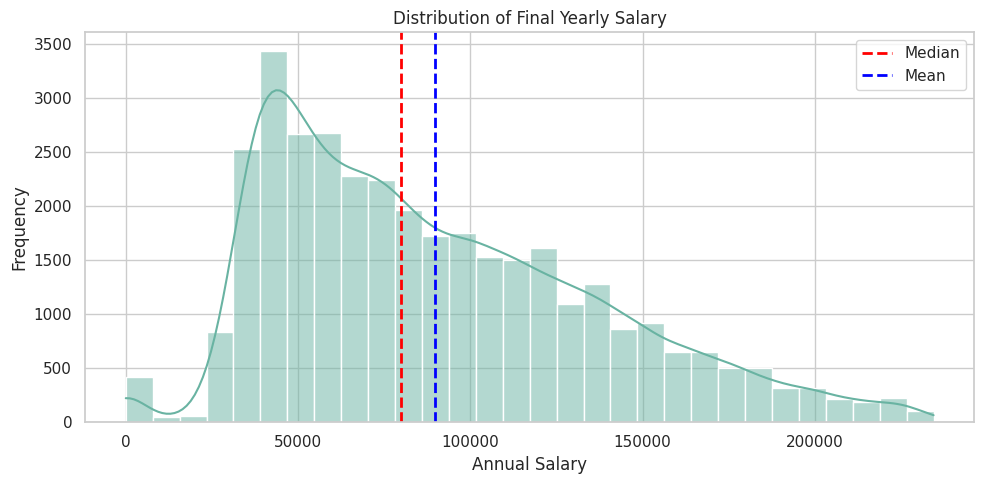

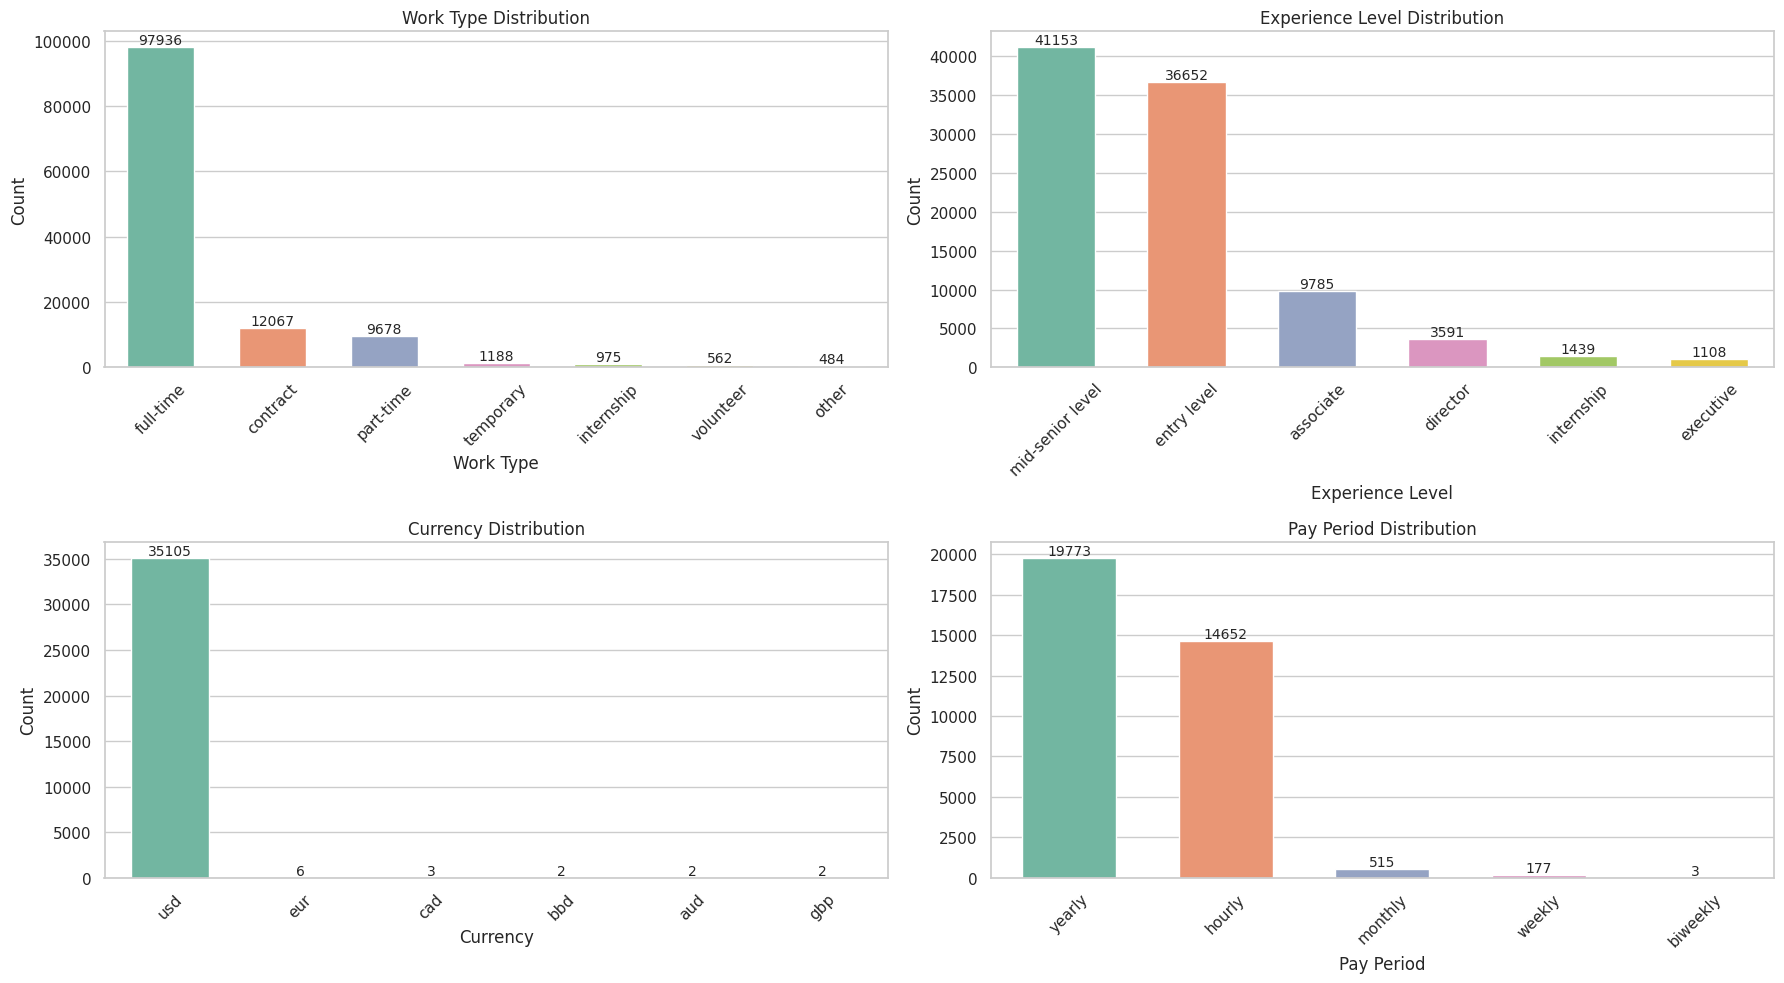

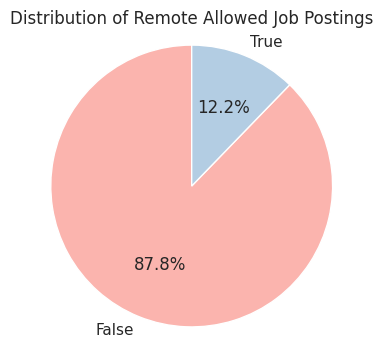

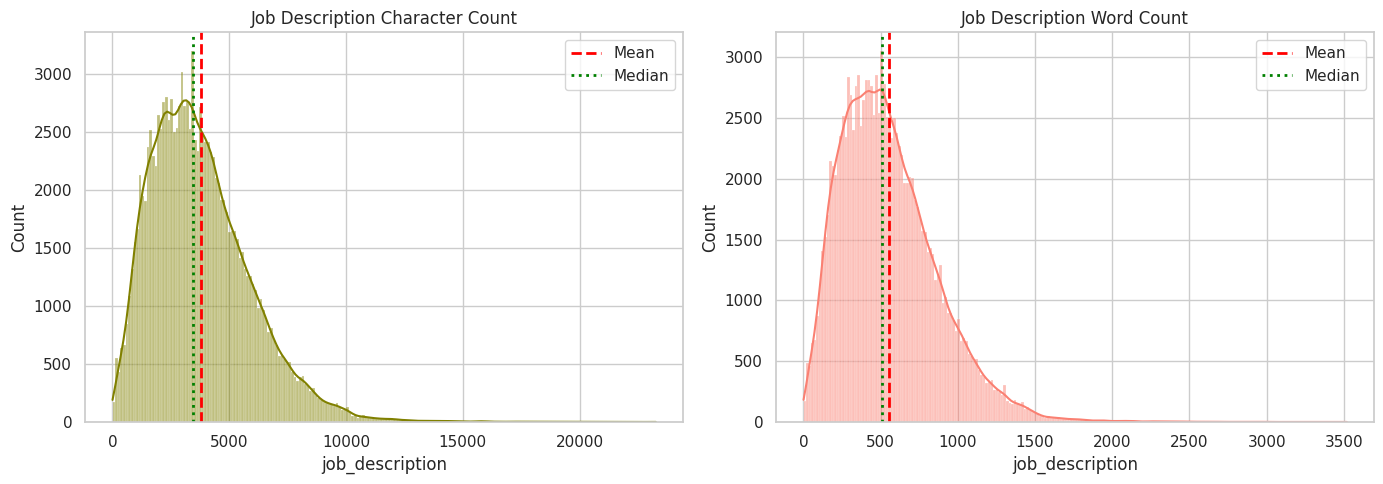

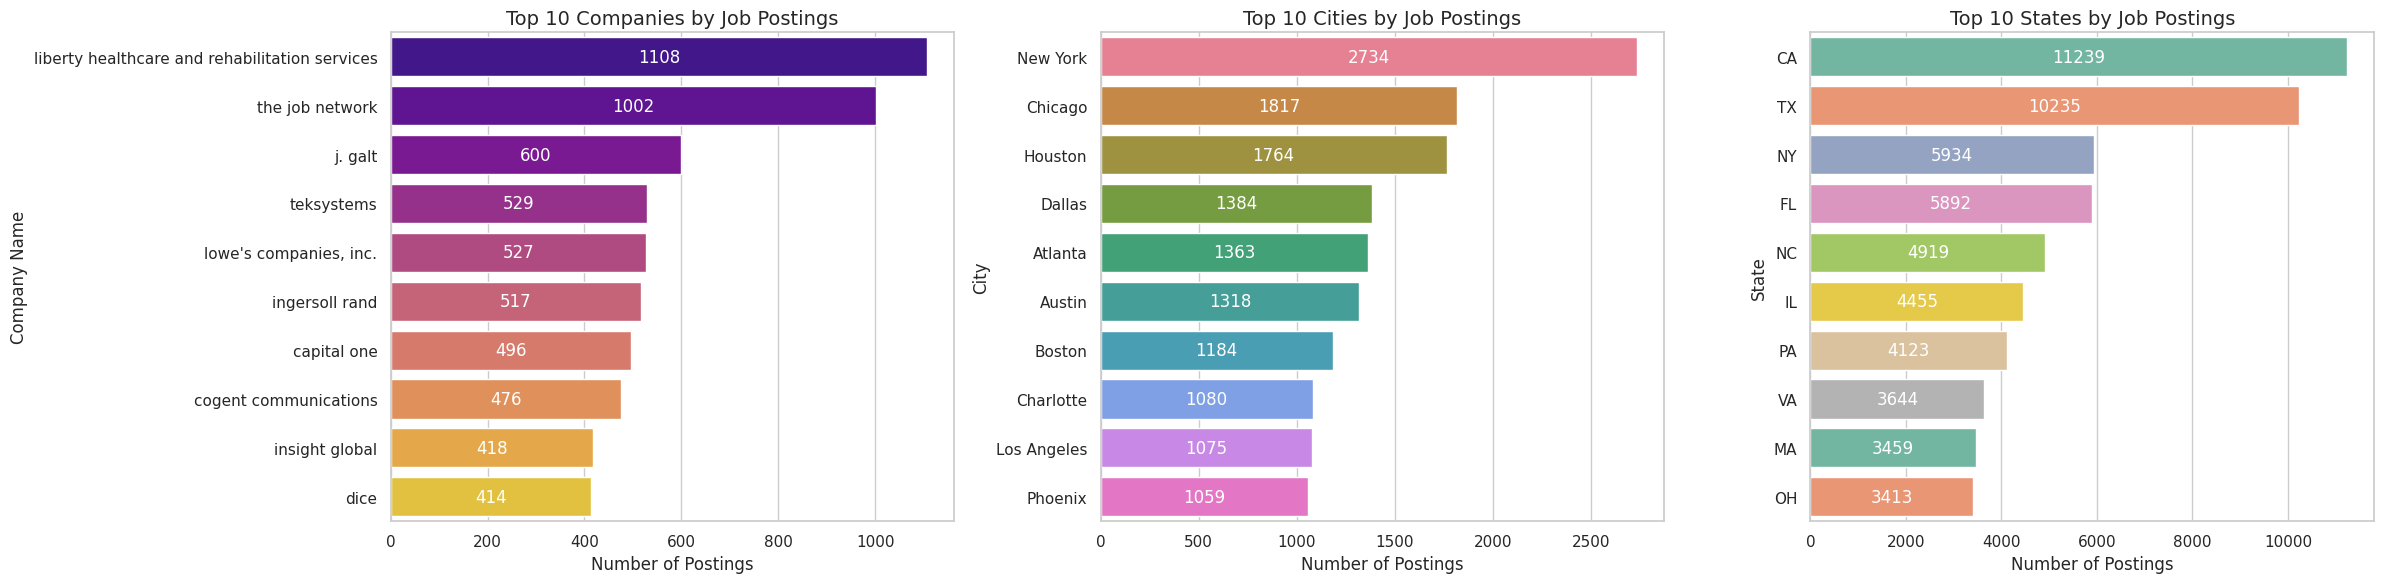

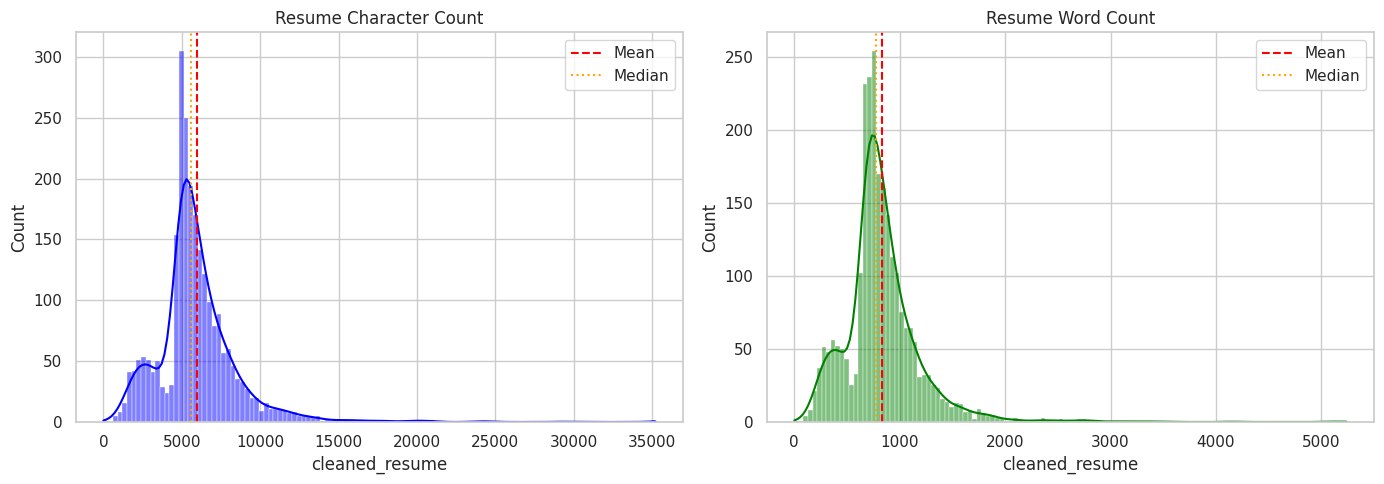

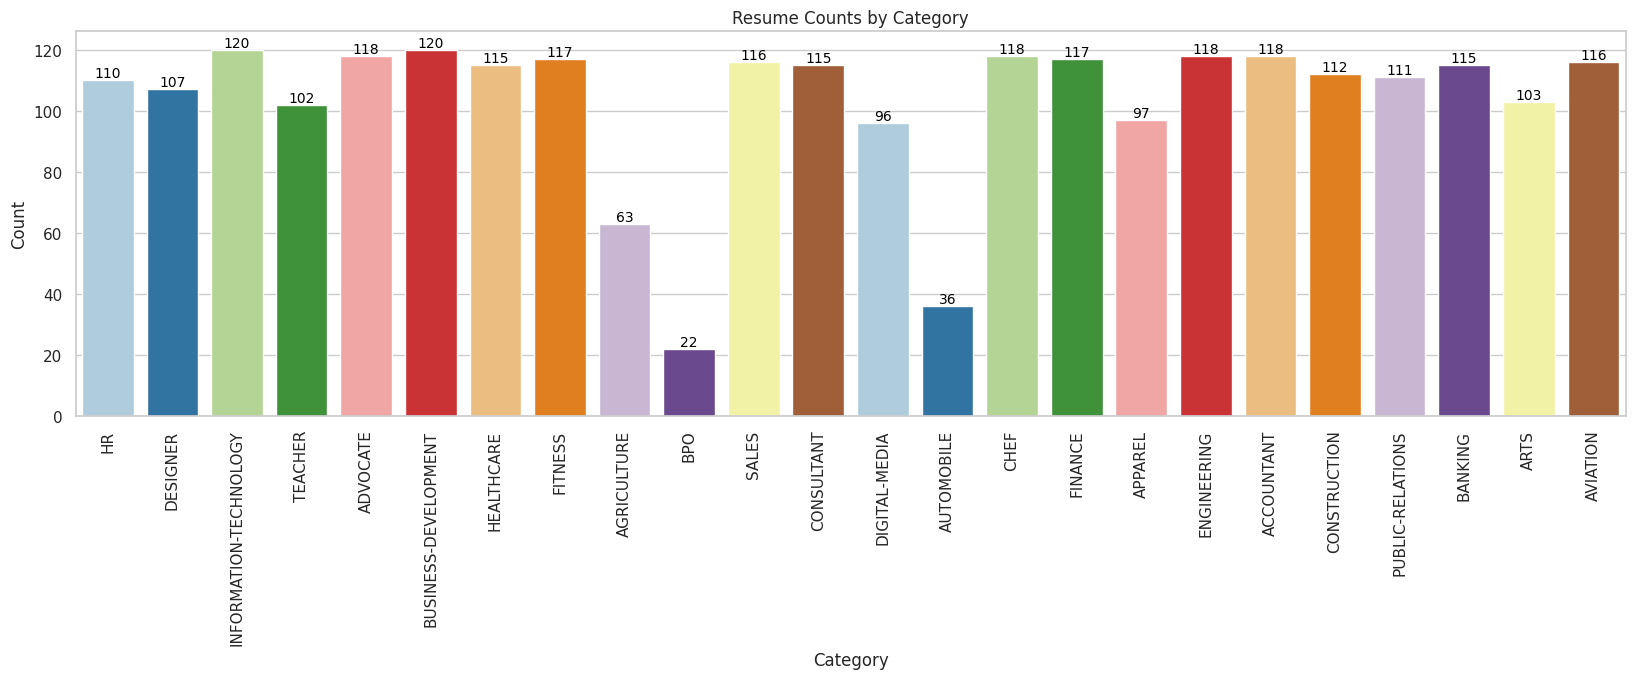

In [ ]:
# ================================================
# Exploratory Data Analysis (EDA) - Job Postings
# ================================================

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

# --- Settings ---
sns.set_style("whitegrid")
sns.set_palette("Set2")

# --- Dataset Summary ---
print("=== Dataset Summary ===")
print(f"Job Postings DF: {job_postings.shape[0]} rows, {job_postings.shape[1]} columns")
print(f"Resume DF: {resume_df.shape[0]} rows, {resume_df.shape[1]} columns")

# ================================================
# --- Univariate Analysis (Job Postings)
# ================================================

# 1. Numeric Feature Distribution
num_cols = ['final_yearly_salary']
fig, ax = plt.subplots(len(num_cols), 1, figsize=(10, 5 * len(num_cols)))

# Ensure ax is iterable
if len(num_cols) == 1:
    ax = [ax]

for i, col in enumerate(num_cols):
    col_data = job_postings[col].dropna()  # Do not alter the original DataFrame

    sns.histplot(col_data, kde=True, bins=30, color="#69b3a2", ax=ax[i])
    ax[i].axvline(col_data.median(), color='red', linestyle='dashed', linewidth=2, label='Median')
    ax[i].axvline(col_data.mean(), color='blue', linestyle='dashed', linewidth=2, label='Mean')
    ax[i].set_title(f"Distribution of {col.replace('_',' ').title()}")
    ax[i].set_xlabel("Annual Salary")
    ax[i].set_ylabel("Frequency")
    ax[i].legend()

plt.tight_layout()
plt.show()


# 2. Categorical Feature Distributions
cat_cols = ['Work_type', 'Experience_level', 'currency', 'pay_period']
n_cols = 2
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    filtered_data = job_postings[job_postings[col] != 'Not Specified']
    sns.countplot(
        x=col,
        data=filtered_data,
        order=filtered_data[col].value_counts().index,
        ax=axes[i],
        palette='Set2',
        width=0.6
    )
    axes[i].set_title(f"{col.replace('_', ' ').title()} Distribution")
    axes[i].set_xlabel(col.replace('_', ' ').title())
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', fontsize=10)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 3. Remote Allowed - Pie Plot
remote_allowed_counts = job_postings['remote_allowed'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(remote_allowed_counts, labels=remote_allowed_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Pastel1'))
plt.title('Distribution of Remote Allowed Job Postings')
plt.axis('equal')
plt.show()

# 4. Job Description Length Analysis (char/word)
if 'job_description' in job_postings.columns:
    job_description_char_count = job_postings['job_description'].dropna().apply(len)
    job_description_word_count = job_postings['job_description'].dropna().apply(lambda x: len(x.split()))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(job_description_char_count, kde=True, ax=axes[0], color='olive')
    axes[0].set_title('Job Description Character Count')
    axes[0].axvline(job_description_char_count.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[0].axvline(job_description_char_count.median(), color='green', linestyle='dotted', linewidth=2, label='Median')
    axes[0].legend()

    sns.histplot(job_description_word_count, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Job Description Word Count')
    axes[1].axvline(job_description_word_count.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[1].axvline(job_description_word_count.median(), color='green', linestyle='dotted', linewidth=2, label='Median')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# 5. Job Postings by Company and Location (City and State)

job_postings_copy = job_postings.copy()

# --- Prepare Top Companies, Cities, and States ---
top_companies = job_postings_copy[job_postings_copy['company_name'] != 'Not Specified']['company_name'].value_counts().index[:10]

# Split city and state from 'job_posting_location' safely
location_parts = job_postings_copy['job_posting_location'].str.split(', ', expand=False)
job_postings_copy['city'] = location_parts.apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
job_postings_copy['state'] = location_parts.apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)

# Filter out 'United States'
filtered_location_data = job_postings_copy[(job_postings_copy['city'] != 'United States') & (job_postings_copy['state'] != 'United States')].copy()

top_cities = filtered_location_data['city'].dropna().value_counts().index[:10]
top_states = filtered_location_data['state'].dropna().value_counts().index[:10]

# --- Create Subplots ---
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
sns.set_palette("Set2")  # Keep your palette consistent

# --- Top 10 Companies ---
sns.countplot(
    y='company_name',
    data=job_postings_copy[job_postings_copy['company_name'].isin(top_companies)],
    order=top_companies,
    ax=axes[0],
    palette='plasma'
)
axes[0].set_title('Top 10 Companies by Job Postings', fontsize=14)
axes[0].set_xlabel('Number of Postings')
axes[0].set_ylabel('Company Name')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='center', color='white')

# --- Top 10 Cities ---
sns.countplot(
    y='city',
    data=filtered_location_data[filtered_location_data['city'].isin(top_cities)],
    order=top_cities,
    ax=axes[1],
    palette='husl'
)
axes[1].set_title('Top 10 Cities by Job Postings', fontsize=14)
axes[1].set_xlabel('Number of Postings')
axes[1].set_ylabel('City')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d', label_type='center', color='white')

# --- Top 10 States ---
sns.countplot(
    y='state',
    data=filtered_location_data[filtered_location_data['state'].isin(top_states)],
    order=top_states,
    ax=axes[2],
    palette='Set2'
)
axes[2].set_title('Top 10 States by Job Postings', fontsize=14)
axes[2].set_xlabel('Number of Postings')
axes[2].set_ylabel('State')
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%d', label_type='center', color='white')

plt.tight_layout()
plt.show()


# ================================================
# --- Univariate Analysis (Resume Dataset)
# ================================================

resume_char_count = resume_df['cleaned_resume'].dropna().apply(len)
resume_word_count = resume_df['cleaned_resume'].dropna().apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(resume_char_count, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Resume Character Count')
axes[0].axvline(resume_char_count.mean(), color='red', linestyle='dashed', label='Mean')
axes[0].axvline(resume_char_count.median(), color='orange', linestyle='dotted', label='Median')
axes[0].legend()

sns.histplot(resume_word_count, kde=True, ax=axes[1], color='green')
axes[1].set_title('Resume Word Count')
axes[1].axvline(resume_word_count.mean(), color='red', linestyle='dashed', label='Mean')
axes[1].axvline(resume_word_count.median(), color='orange', linestyle='dotted', label='Median')
axes[1].legend()

plt.tight_layout()
plt.show()

# Resume Category Count
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="Category", data=resume_df, palette='Paired')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.title("Resume Counts by Category")
plt.ylabel("Count")
plt.xlabel("Category")
plt.xticks(rotation=90)
plt.show()

## Bivariate Analysis

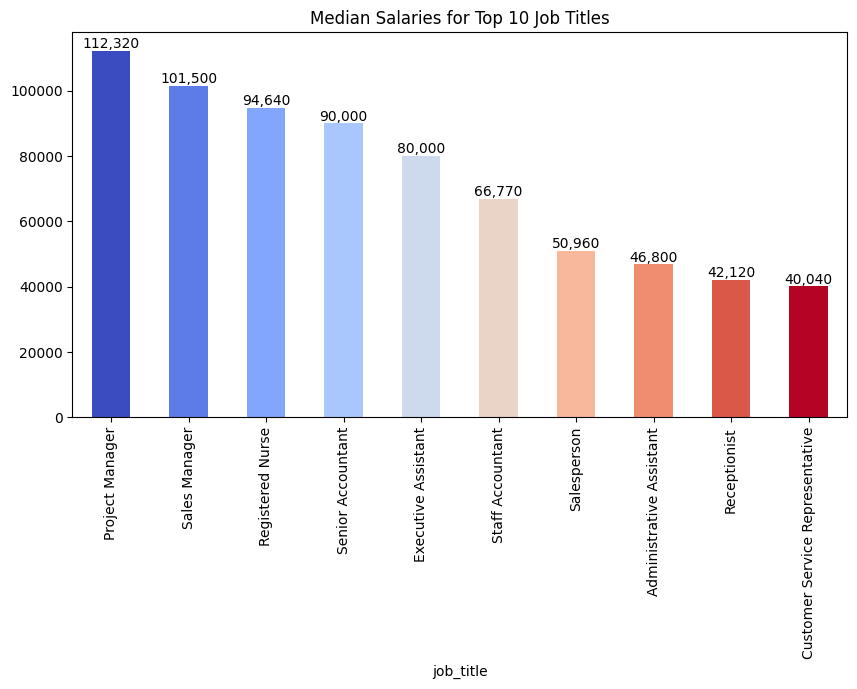

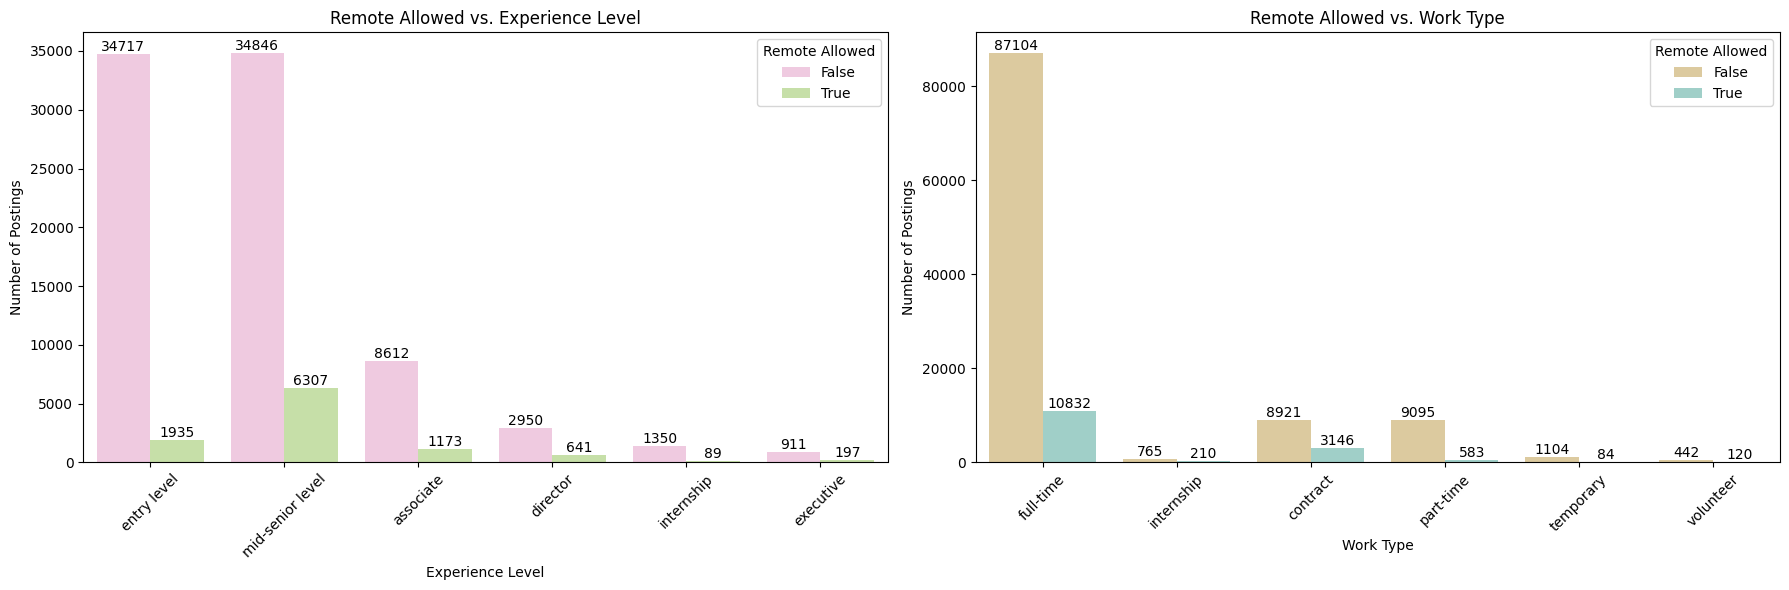

/tmp/ipython-input-2375224028.py:62: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




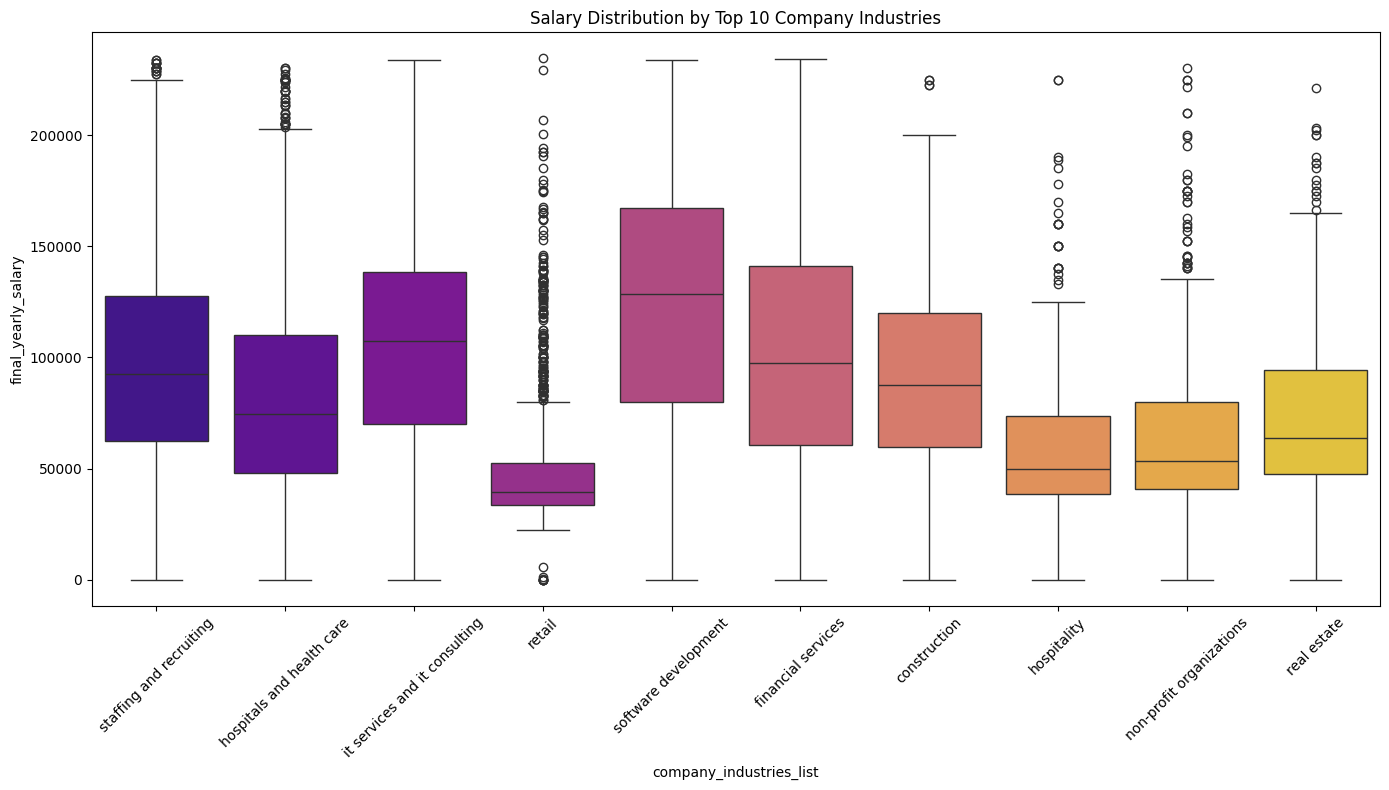

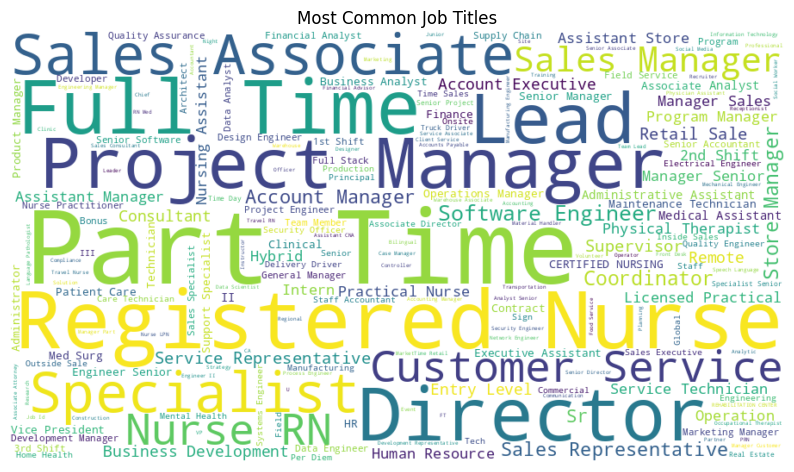

In [46]:
# ================================================
# --- Bivariate Analysis (Job Postings)
# ================================================

# 1. Final Salary vs. Experience Level (Box Plot)
fig = px.box(
    job_postings[job_postings['Experience_level'] != 'not specified'],
    x='Experience_level',
    y='final_yearly_salary',
    color='Experience_level',
    title='Annual Salary Distribution by Experience Level',
    width=950, height=500
)
fig.show()

# 2. Median Salary by Top 10 Job Titles
top_titles = job_postings['job_title'].value_counts().index[:10]
top_titles_data = job_postings[job_postings['job_title'].isin(top_titles)]
median_salaries = top_titles_data.groupby('job_title')['final_yearly_salary'].median().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(median_salaries)))
ax = median_salaries.plot(kind='bar', color=colors)
plt.title('Median Salaries for Top 10 Job Titles')
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')
plt.show()

# 3. Remote Allowed vs Experience Level
filtered_job_postings_remote_exp = job_postings[(job_postings['Experience_level'] != 'not specified')]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax0 = sns.countplot(x='Experience_level', hue='remote_allowed', data=filtered_job_postings_remote_exp, palette='PiYG', ax=axes[0])
axes[0].set_title('Remote Allowed vs. Experience Level')
axes[0].set_xlabel('Experience Level')
axes[0].set_ylabel('Number of Postings')
axes[0].tick_params(axis='x', rotation=45)
for container in ax0.containers:
    ax0.bar_label(container, fmt='%d')
axes[0].legend(title='Remote Allowed')

4. # Remote Allowed vs Work Type
filtered_job_postings_remote_work = job_postings[(job_postings['Work_type'] != 'other')]
ax1 = sns.countplot(x='Work_type', hue='remote_allowed', data=filtered_job_postings_remote_work, palette='BrBG', ax=axes[1])
axes[1].set_title('Remote Allowed vs. Work Type')
axes[1].set_xlabel('Work Type')
axes[1].set_ylabel('Number of Postings')
axes[1].tick_params(axis='x', rotation=45)
# Add count labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d')
axes[1].legend(title='Remote Allowed')

plt.tight_layout()
plt.show()

# 5. Salary by Top 10 Industries (Box Plot)
top_industries = job_postings['company_industries_list'].value_counts().index[:10]
filtered_industry_data = job_postings[job_postings['company_industries_list'].isin(top_industries)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='company_industries_list', y='final_yearly_salary', data=filtered_industry_data, palette='plasma', order=top_industries)
plt.title('Salary Distribution by Top 10 Company Industries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Word Cloud for Job Titles
all_titles = " ".join(job_postings['job_title'].dropna())
wordcloud = WordCloud(width=900, height=500, background_color='white').generate(all_titles)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Job Titles')
plt.show()

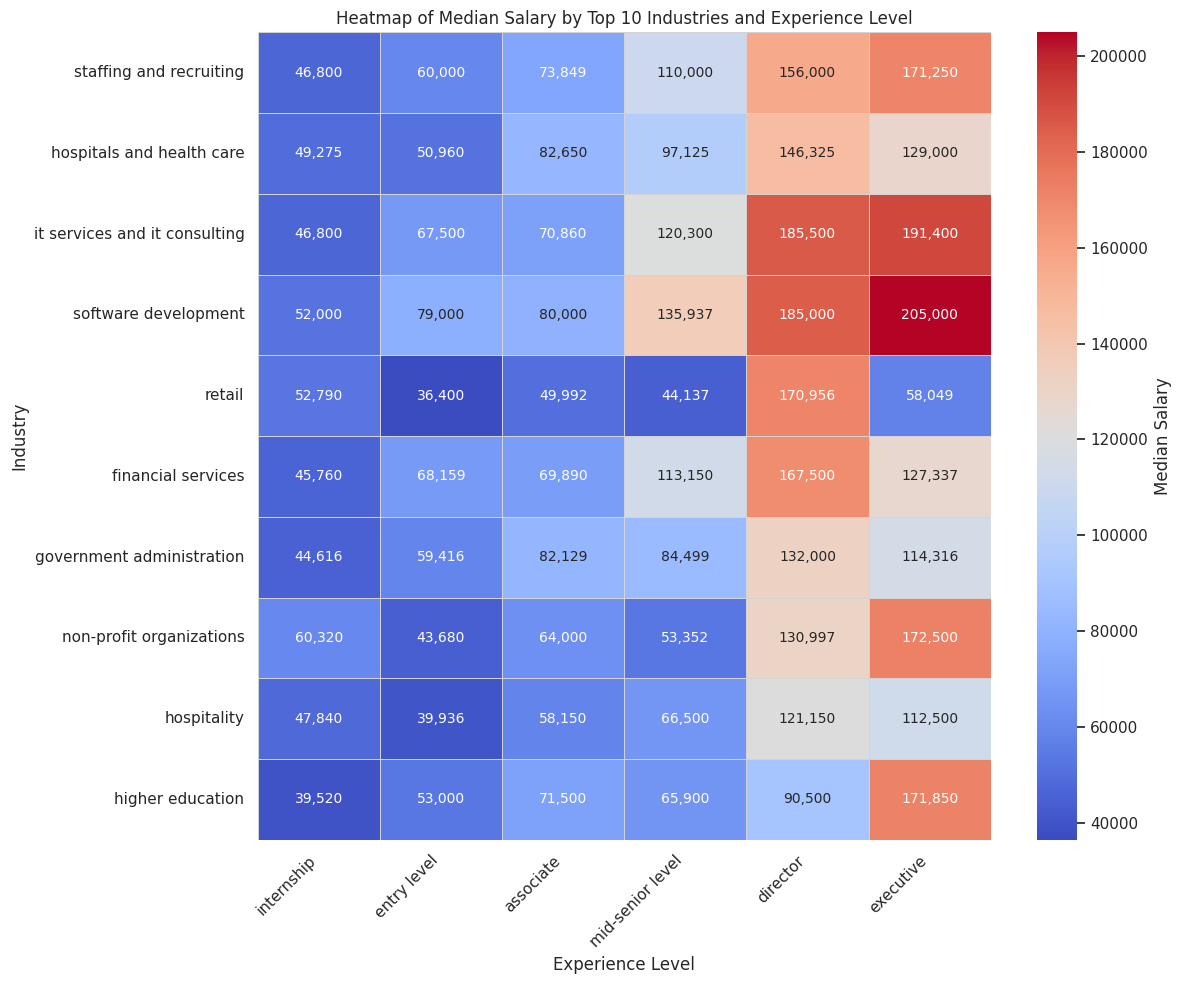

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Import numpy for nan handling

experience_level_order = [
    'internship',
    'entry level',
    'associate',
    'mid-senior level',
    'director',
    'executive'
]

# Filter out 'Not Specified' industries and experience levels, and rows with NaN salaries
filtered_job_postings_salary_heatmap = job_postings[
    (job_postings['company_industries_list'] != 'not specified') &
    (job_postings['Experience_level'] != 'not specified') &
    (job_postings['final_yearly_salary'].notna())
].copy()

# Identify top 20 industries by job posting count from the filtered data
top_industries_for_heatmap = filtered_job_postings_salary_heatmap['company_industries_list'].value_counts().index[:10]

# Filter the data to include only top industries
filtered_job_postings_salary_heatmap = filtered_job_postings_salary_heatmap[
    filtered_job_postings_salary_heatmap['company_industries_list'].isin(top_industries_for_heatmap)
]

# Group by 'company_industries_list' and 'Experience_level' and calculate median salary
median_salary_heatmap_data = filtered_job_postings_salary_heatmap.groupby(['company_industries_list', 'Experience_level'])['final_yearly_salary'].median().reset_index()

# Pivot the data to prepare for the heatmap
pivot_table = median_salary_heatmap_data.pivot(index='company_industries_list', columns='Experience_level', values='final_yearly_salary')

# Explicitly remove 'Not Specified' from index and columns if present
if 'Not specified' in pivot_table.index:
    pivot_table = pivot_table.drop(index='Not Specified')
if 'Not specified' in pivot_table.columns:
    pivot_table = pivot_table.drop(columns='Not Specified')


# Reorder the columns (Experience Level) according to the specified order, dropping any levels not in the data
pivot_table = pivot_table[experience_level_order].dropna(axis=1, how='all') # Drop columns that are all NaN after reindexing


# Ensure the index (Industry) is ordered by the top industries identified, dropping any industries not in the data
pivot_table = pivot_table.reindex(top_industries_for_heatmap).dropna(axis=0, how='all') # Drop rows that are all NaN after reindexing


# Custom formatter to add commas to the annotations
def with_commas(val):
    if pd.isna(val):
        return '' # Return empty string for NaN values
    return "{:,}".format(int(val))

# Create and display the heatmap
plt.figure(figsize=(12, 10)) # Adjusted figure size for better readability with 20 industries
sns.heatmap(pivot_table, annot=True, fmt="", cmap='coolwarm',
            cbar_kws={'label': 'Median Salary'},
            annot_kws={'size': 10, 'va': 'center', 'ha': 'center'}, # Adjusted annotation size
            linewidths=.5, # Added linewidths for separation
            linecolor='lightgray' # Added linecolor
            )
plt.title('Heatmap of Median Salary by Top 10 Industries and Experience Level')
plt.ylabel('Industry')
plt.xlabel('Experience Level')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.yticks(rotation=0) # Keep y-axis labels horizontal

# Apply the custom formatter to each text annotation in the heatmap
for text in plt.gca().texts:
    try:
        # Get the numerical value from the text
        val = float(text.get_text().replace(',', '')) # Remove commas before converting to float
        text.set_text(with_commas(val))
    except ValueError:
        # Handle cases where text is not a number (e.g., empty string for NaN)
        pass


plt.tight_layout()
plt.show()

## Detailed Summary of Data Description and Exploratory Data Analysis

This section details the initial phase of the job-resume matching project, encompassing data loading, cleaning, preprocessing, and a comprehensive exploratory data analysis (EDA) to understand the characteristics and structure of the datasets.

### Data Loading and Initial Inspection

The project utilizes two primary datasets: LinkedIn job postings and a resume dataset. The job postings dataset, sourced from Kaggle, includes several related files: `postings.csv`, `job_skills.csv`, `salaries.csv`, `skills.csv`, `companies.csv`, and `company_industries.csv`. The resume dataset, also from Kaggle, is provided in `Resume.csv`.

The datasets were loaded into pandas DataFrames using the `kagglehub` library to access the data files from their respective paths. Initial inspection of the DataFrames (`job_postings`, `job_skills`, `salaries`, `skills`, `companies`, `company_industries`, and `resume_df`) provided a first look at the column names, data types, and a few rows of each dataset.

### Data Cleaning and Preprocessing

The data cleaning and preprocessing stage focused on integrating the related job postings datasets and preparing both the consolidated job data and the resume data for analysis.

**1. Skills Data Aggregation:**
The `job_skills` and `skills` DataFrames were merged on `skill_abr` to link job postings to skill names. Skills for each job were then aggregated into a comma-separated list in a new column, `skills_list`.

**2. Company Data Aggregation:**
The `companies` and `company_industries` DataFrames were merged on `company_id`. Company industries for each company were aggregated into a comma-separated list in `company_industries_list`. Relevant company information such as size, location (state, country, city, address, zip code), and name were also prepared for merging with the main job postings data.

**3. Salary Data Processing:**
The `salaries` DataFrame contained salary information with different `pay_period` values. A function was implemented to standardize salaries to a `calculated_yearly_salary` based on the `pay_period` and available salary fields (`min_salary`, `max_salary`, `med_salary`). The median calculated yearly salary was then determined for each `job_id`.

**4. Main Data Merging:**
The primary `job_postings` DataFrame was sequentially merged with the processed salary data, company information, aggregated company industries, and aggregated skills data. Redundant or less relevant columns from the original and intermediate DataFrames were dropped to create a `final_job_df` with a consolidated view of job posting information. A new column, `final_yearly_salary`, was created, prioritizing `normalized_salary` and falling back to `calculated_yearly_salary`.

**5. Resume Data Cleaning:**
The `Resume_html` column was dropped from the `resume_df` as the raw text in `Resume_str` was deemed sufficient for the intended analysis.

**6. Duplicate Removal:**
Duplicates were checked and removed from `final_job_df` based on `job_id` (no duplicates found) and from `resume_df` based on `Resume_str` (2 duplicates removed), ensuring unique entries in both datasets.

**7. Standardizing Column Formats and Handling Missing Values:**
Missing values in `final_job_df` were analyzed. Columns with a high percentage of missing values like `skills_description`, `remote_allowed`, `currency`, `pay_period`, `compensation_type`, and `final_yearly_salary` were identified. `remote_allowed` was filled with 0 (representing False) and converted to boolean. `final_yearly_salary` was converted to numeric. Text-based columns were converted to lowercase strings, leading/trailing whitespace was removed, and 'nan' strings were replaced with 'Not Specified'. Rows with missing `job_description` were dropped. The `resume_df` had no missing values in its relevant columns.

**8. Text Cleaning with NLP:**
A custom `clean_text` function was developed to preprocess the long text fields (`job_description`, in `final_job_df` and `Resume_str` in `resume_df`). This function handled special characters, newlines, spacing issues, and normalized bullet points. The cleaned text was stored in new columns (`cleaned_job_description`, `cleaned_skills_description`, `cleaned_resume`). The original text columns were then dropped, and the cleaned columns were renamed to their original names.

### Statistical Summary and Outlier Detection

A statistical summary of the numerical columns in `final_job_df` (`job_id`, `sponsored`, `final_yearly_salary`) was generated to understand the central tendency, dispersion, and range of these attributes.

Outlier detection was performed using the Interquartile Range (IQR) method for numerical columns. Outliers were identified in `job_id` and `final_yearly_salary`. For `final_yearly_salary`, outliers were removed to mitigate their potential impact on subsequent analysis, while retaining rows where the salary was originally missing. The resulting DataFrame, `job_postings`, was used for further analysis.

### Exploratory Data Analysis (EDA)

Univariate and bivariate analyses were conducted to explore the distributions of individual features and the relationships between pairs of features in both the job postings and resume datasets.

**Univariate Analysis (Job Postings):**

*   **Distribution of Final Yearly Salary:** A histogram with KDE plot revealed a right-skewed distribution, indicating that a majority of job postings offer salaries at the lower end of the spectrum, with fewer high-paying positions. The median salary was lower than the mean, consistent with the skewness.
*   **Categorical Feature Distributions:** Count plots for `Work_type`, `Experience_level`, `currency`, `pay_period`, and `compensation_type` (excluding 'Not Specified' entries) showed the frequency of different categories within these features. 'Full-time' was the dominant `Work_type`. 'Mid-senior level' and 'associate' were the most frequent `Experience_level` categories. 'USD' was the prevalent `currency`, and 'yearly' and 'hourly' were the most common `pay_period` values. 'Base_salary' was the most frequent `compensation_type`.
*   **Distribution of Remote Allowed:** A pie chart illustrated that a significant majority of job postings did not allow for remote work.
*   **Job Description Length Analysis:** Histograms of character and word counts for job descriptions showed right-skewed distributions, indicating that most job descriptions are relatively concise.
*   **Job Postings by Company and Location:** Count plots for the top 10 companies, cities, and states (excluding "United States") by job posting count highlighted the major employers and geographical areas with the highest volume of job opportunities in the dataset.

**Univariate Analysis (Resume Dataset):**

*   **Resume Length Distribution:** A histogram of word counts for cleaned resumes showed a right-skewed distribution, suggesting that most resumes fall within a moderate length range.
*   **Resume Category Count:** A bar plot displayed the number of resumes within each category, revealing the distribution of resume types in the dataset.

**Bivariate Analysis (Job Postings):**

*   **Salary Distribution by Experience Level:** A box plot showed a general trend of increasing median salary with higher experience levels, with 'executive' and 'director' roles commanding the highest median pay.
*   **Median Salary by Top 10 Job Titles:** A bar plot visualized the median salaries for the ten most frequently occurring job titles, providing a direct comparison of typical compensation for common roles.
*   **Remote Allowed vs. Experience Level:** A count plot with hue illustrated the proportion of remote jobs within different experience levels, showing that remote options are available across various experience levels.
*   **Remote Allowed vs. Work Type:** A count plot with hue displayed the distribution of remote allowed status across different work types, highlighting which work types are more likely to offer remote flexibility.
*   **Salary Distribution by Top 10 Industries:** A box plot showed variations in salary distributions across the top 10 industries, suggesting industry-specific pay scales and salary ranges.
*   **Word Cloud for Job Titles:** A word cloud generated from the job titles provided a visual representation of the most frequently mentioned job titles in the job postings.
*   **Heatmap of Median Salary by Top 10 Industries and Experience Level:** A heatmap provided a detailed view of the median salary for combinations of the top 10 industries and different experience levels, highlighting potential high-paying industry-experience level niches.

This comprehensive data description and exploratory data analysis provide a foundational understanding of the characteristics and relationships within the job postings and resume datasets, informing subsequent stages of the job-resume matching project.